In [671]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()

In [672]:
triangulation_results_path = f"{root}/data/stereo_detections_triangulated.csv"
triangulation_results = pd.read_csv(triangulation_results_path)
triangulation_results.sort_values(by='frame_no', inplace=True)

with pd.option_context('display.max_colwidth', None):
  print(triangulation_results['position_3d_pixels'].head())

0       [3748.34950574466, -489.8600736323993, 4286.859981600735]
1      [3491.804443536914, -456.8706049838067, 4269.054799920354]
2     [3180.6963959369436, -416.8508687861151, 4172.307555379583]
3     [3830.540950410358, -433.39021907640875, 5382.764621454251]
4    [3835.8875062889883, -437.38462018886327, 5396.051789531503]
Name: position_3d_pixels, dtype: object


In [673]:
frame_start, frame_end = 900, 1000

filtered_shot = triangulation_results.loc[
    (triangulation_results['frame_no'] >= frame_start) &
    (triangulation_results['frame_no'] <= frame_end)
].copy()

# Savitzky-Golay Filter

In [674]:
import numpy as np
import ast
from scipy.signal import savgol_filter

points_3d = np.array([ast.literal_eval(p) for p in filtered_shot['position_3d_pixels']])
z_vals = points_3d[:, 2]

z_smooth = savgol_filter(z_vals, window_length=7, polyorder=2)

# Optional: Add to DataFrame
filtered_shot['z'] = z_vals
filtered_shot['z_smooth'] = z_smooth


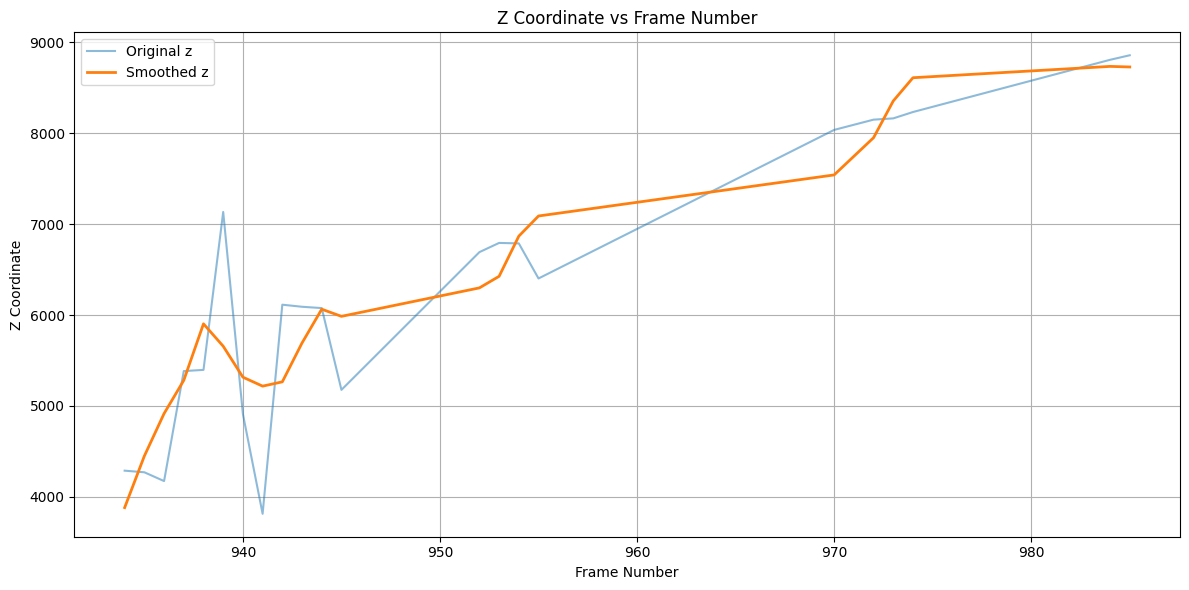

In [675]:
def plot_z_vs_frame(frame_no, z, z_smooth=None):
    plt.figure(figsize=(12, 6))

    # Plot original z
    plt.plot(frame_no, z, label='Original z', alpha=0.5)

    # Plot smoothed z if provided
    if z_smooth is not None:
        plt.plot(frame_no, z_smooth, label='Smoothed z', linewidth=2)

    plt.xlabel('Frame Number')
    plt.ylabel('Z Coordinate')
    plt.title('Z Coordinate vs Frame Number')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_z_vs_frame(
    frame_no=filtered_shot['frame_no'],
    z=filtered_shot['z'],
    z_smooth=filtered_shot['z_smooth']  # optional
)

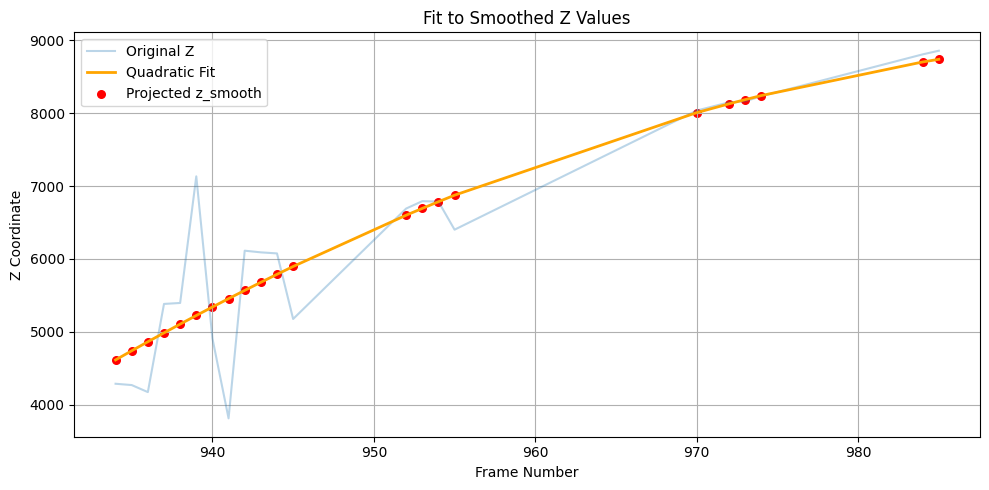

In [676]:
import numpy as np
import matplotlib.pyplot as plt

# Extract frame numbers and smoothed z values
frame = filtered_shot['frame_no'].values
z = filtered_shot['z_smooth'].values

# Fit a 2nd-degree polynomial: z = a*frame^2 + b*frame + c
coeffs = np.polyfit(frame, z, deg=2)
poly = np.poly1d(coeffs)

# Evaluate polynomial at the original frame values
z_fit = poly(frame)

# Store the fit in your DataFrame if you want to use it later
filtered_shot['z_smooth'] = z_fit

plt.figure(figsize=(10, 5))
plt.plot(frame, filtered_shot['z'], label='Original Z', alpha=0.3)
plt.plot(frame, z_fit, label='Quadratic Fit', color='orange', linewidth=2)
plt.scatter(frame, z_fit, color='red', label='Projected z_smooth', s=30)
plt.xlabel("Frame Number")
plt.ylabel("Z Coordinate")
plt.title("Fit to Smoothed Z Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Rolling Smooth Window

In [677]:
# filtered_shot['z_smooth'] = filtered_shot['z'].rolling(window=5, center=True).mean()

# plot_z_vs_frame(
#     frame_no=filtered_shot['frame_no'],
#     z=filtered_shot['z'],
#     z_smooth=filtered_shot['z_smooth']
# )

# Update stereo_detections_triangulation.csv to use 'z_smooth'

In [678]:
coords = np.array([ast.literal_eval(p) for p in filtered_shot['position_3d_pixels']])

# Extract the X and Y components from coords and the smoothed Z from the DataFrame
filtered_shot['position_3d_pixels_smooth'] = [
    [float(x), float(y), float(z)]
    for (x, y), z in zip(coords[:, :2], filtered_shot['z_smooth'])
]

# Drop helper columns
filtered_shot.drop(['z', 'z_smooth'], axis=1, inplace=True)

# Save to CSV
filtered_shot.to_csv(f"{root}/data/stereo_detections_triangulated_with_smooth.csv", index=False)

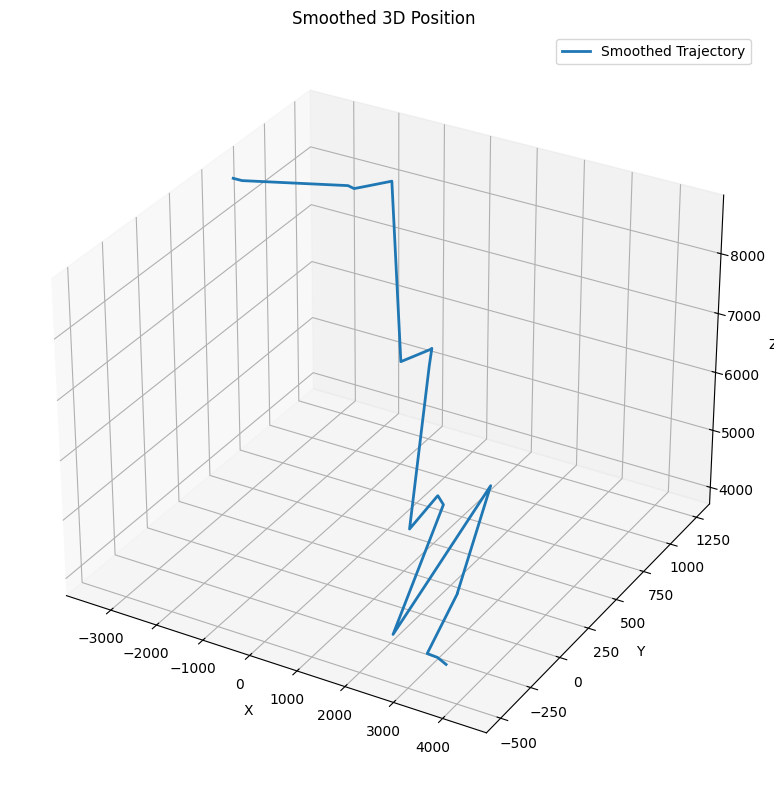

In [679]:
def plot_3d_trajectory(coords, title='3D Trajectory'):

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], label='Smoothed Trajectory', linewidth=2)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()
    

plot_3d_trajectory(coords, title='Smoothed 3D Position')


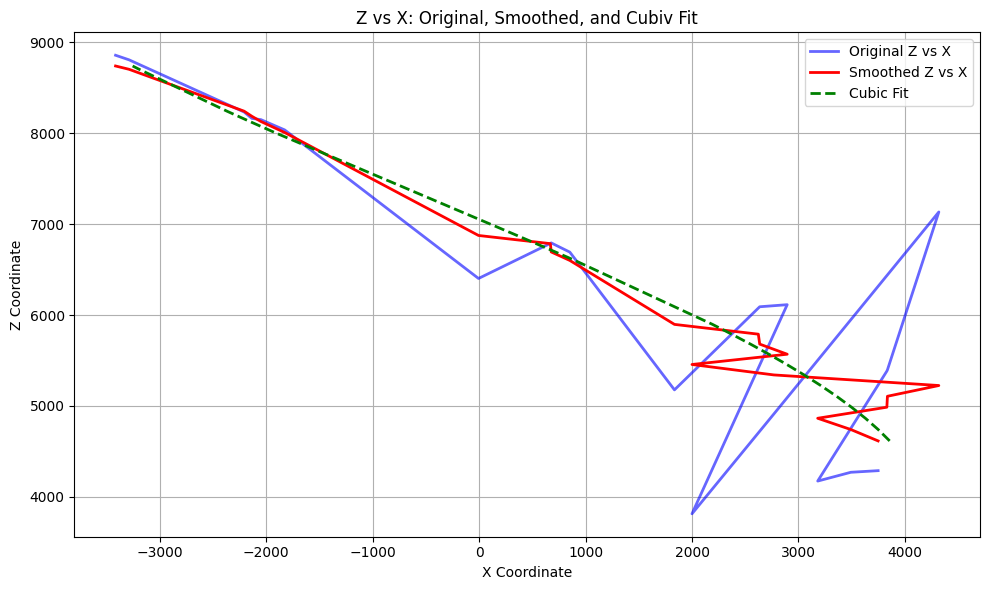

In [680]:
original_coords = np.array([ast.literal_eval(p) for p in filtered_shot['position_3d_pixels']])
smooth_coords = np.array(list(filtered_shot['position_3d_pixels_smooth']))

x_orig, z_orig = original_coords[:, 0], original_coords[:, 2]
x_smooth, z_smooth = smooth_coords[:, 0], smooth_coords[:, 2]

coeffs = np.polyfit(z_smooth, x_smooth, deg=3)
poly = np.poly1d(coeffs)


x_fit = poly(z_smooth)
filtered_shot['x_smooth'] = x_fit

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_orig, z_orig, label='Original Z vs X', color='blue', alpha=0.6, linewidth=2)
plt.plot(x_smooth, z_smooth, label='Smoothed Z vs X', color='red', linewidth=2)
plt.plot(x_fit,z_smooth, label='Cubic Fit', color='green', linestyle='--', linewidth=2)

plt.xlabel('X Coordinate')
plt.ylabel('Z Coordinate')
plt.title('Z vs X: Original, Smoothed, and Cubiv Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [681]:
x_smooth = np.array(filtered_shot['x_smooth'])

valid_indices = [0]  # Always keep the first point
print(f"Index 0: x = {x_smooth[0]:.4f} (kept)")

for i in range(1, len(x_smooth)):
    prev_x = x_smooth[i - 1]
    curr_x = x_smooth[i]
    
    if curr_x < prev_x:
        valid_indices.append(i)
        print(f"Index {i}: x = {curr_x:.4f} < {prev_x:.4f} → kept")
    else:
        print(f"Index {i}: x = {curr_x:.4f} >= {prev_x:.4f} → removed")

# Filter DataFrame
filtered_shot = filtered_shot.iloc[valid_indices].reset_index(drop=True)


Index 0: x = 3856.9135 (kept)
Index 1: x = 3748.8617 < 3856.9135 → kept
Index 2: x = 3628.8803 < 3748.8617 → kept
Index 3: x = 3498.1812 < 3628.8803 → kept
Index 4: x = 3357.9134 < 3498.1812 → kept
Index 5: x = 3209.1646 < 3357.9134 → kept
Index 6: x = 3052.9632 < 3209.1646 → kept
Index 7: x = 2890.2805 < 3052.9632 → kept
Index 8: x = 2722.0324 < 2890.2805 → kept
Index 9: x = 2549.0810 < 2722.0324 → kept
Index 10: x = 2372.2373 < 2549.0810 → kept
Index 11: x = 2192.2618 < 2372.2373 → kept
Index 12: x = 899.0025 < 2192.2618 → kept
Index 13: x = 715.9588 < 899.0025 → kept
Index 14: x = 534.6733 < 715.9588 → kept
Index 15: x = 355.5017 < 534.6733 → kept
Index 16: x = -1921.6438 < 355.5017 → kept
Index 17: x = -2154.5355 < -1921.6438 → kept
Index 18: x = -2264.3852 < -2154.5355 → kept
Index 19: x = -2369.8685 < -2264.3852 → kept
Index 20: x = -3195.4019 < -2369.8685 → kept
Index 21: x = -3256.4705 < -3195.4019 → kept


In [682]:
smooth_coords = np.array(list(filtered_shot['position_3d_pixels_smooth']))

# Extract the X and Y components from coords and the smoothed Z from the DataFrame
filtered_shot['position_3d_pixels_smooth'] = [
    [float(x_smooth), float(y), float(z)]
    for x_smooth, (y, z) in zip(filtered_shot['x_smooth'], smooth_coords[:, 1:3])
]

# Drop helper columns
filtered_shot.drop(['x_smooth'], axis=1, inplace=True)

# Save to CSV
filtered_shot.to_csv(f"{root}/data/stereo_detections_triangulated_with_smooth.csv", index=False)